Project 1: What factors have contributed to the spread of COVID-19 in different regions of the world

In [82]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
import json 
import time

In [83]:
# Retrieve Datasets

path_covid_country = r"Dataset\Covid\country_wise_latest.csv"
path_covid_complete = r"Dataset\Covid\covid_19_clean_complete.csv"
path_air_quality = r"Dataset\Air Quality\World_cities_air_quality_and_water_pollution_2020.csv"
path_air_pollution=r"Dataset\Air Quality\World_most_polluted_countries_regions_historical_data _2018-2021.csv"
path_government_resp = r"Dataset\Government_response\COVID_gov_complete_29_03.csv"
path_vaccination_cases = r"Dataset\Vaccination\df_covid19_countries_cases.csv"
path_vaccination_rate = r"Dataset\Vaccination\df_covid19_countries_vaccination.csv"
path_weather = r"Dataset\Weather\training_data_with_weather_info_week_4.csv"


covid_country_df = pd.read_csv(path_covid_country)
covid_complete_df = pd.read_csv(path_covid_complete)
air_quality_df = pd.read_csv(path_air_quality)
air_pollution_df=pd.read_csv(path_air_pollution,index_col=0)
government_resp_df = pd.read_csv(path_government_resp)
vaccination_cases_df = pd.read_csv(path_vaccination_cases)
vaccination_rate_df = pd.read_csv(path_vaccination_rate)
weather_df = pd.read_csv(path_weather)

In [84]:
air_pollution_df

,Rank,Country/Region,2021,2020,2019,2018,Population
0,1,Bangladesh,76.9,77.1,83.3,97.1,164689383
1,2,Chad,75.9,-,-,-,16425859
2,3,Pakistan,66.8,59,65.8,74.3,220892331
3,4,Tajikistan,59.4,30.9,-,-,9537642
4,5,India,58.1,51.9,58.1,72.5,1380004385
...,...,...,...,...,...,...,...
112,113,"Bonaire, Saint Eustatius and Saba",5.1,-,-,-,26221
113,114,Cape Verde,5.1,-,-,-,555988
114,115,Puerto Rico,4.8,3.7,10.2,13.7,2860840
115,116,U.S. Virgin Islands,4.5,3.7,3.5,-,104423


Factor 1: Impact of climate on the spread of Covid-19 (Kevin Guillemette)

Factor 2: Impact of Government Response on the spread of Covid-19 (Helena Fedorenko)

Factor 3: Impact of Vaccination Rate on the spread & severity of Covid-19 (Brecht Nys)

In [85]:
# Merge two datasets

vaccination_df = pd.merge(vaccination_cases_df, vaccination_rate_df,on=["location", "date"])

# Remove unnecessary columns

vaccination_df = vaccination_df[["location",
                                 "date",
                                 "total_cases",
                                 "total_deaths",
                                 "new_deaths",
                                 "reproduction_rate",
                                 "people_vaccinated",
                                 "people_fully_vaccinated",
                                 "population"]]

- reproduction_rate
    The R number is a way of rating coronavirus or any disease's ability to spread.
    R is the number of people that one infected person will pass on a virus to, on average.
    If the R value is higher than one, then the number of cases keeps increasing.
- people_vaccinated: at least 1 vaccination
- people_fully_vaccinate: all required vaccinations
- vaccination_ratio: people_vaccinated / population


In [86]:
# Add necessary columns

vaccination_rate = []
fully_vaccination_rate = []
death_rate = []

for index, row in vaccination_df.iterrows():
    current_population = row["population"]
    current_vaccinated = row["people_vaccinated"]
    current__fully_vaccinated = row["people_fully_vaccinated"]
    current_total_cases = row["total_cases"]
    current_new_deaths = row["total_deaths"]
        
    vaccination_rate.append((current_vaccinated/current_population)*100)
    fully_vaccination_rate.append((current__fully_vaccinated/current_population)*100)
    if current_total_cases == 0:
        death_rate.append(0)
    else:
        death_rate.append((current_new_deaths/current_total_cases)*100)
    
vaccination_df["Vaccination Rate"] = vaccination_rate
vaccination_df["Fully Vaccinated Rate"] = fully_vaccination_rate
vaccination_df["Death Rate"] = death_rate


In [87]:
# Map Country to Continent

country_names = vaccination_df["location"].unique()
continent_name = [ ]

for country in country_names:
    country_url = "https://restcountries.com/v3.1/name/"
    response = requests.get(country_url + country).json()

    try:
        continent = response[0]["region"]
    except:
        continent = "Unknown"
    continent_name.append(continent)
    time.sleep(0.5)
    
country_mapping_df = pd.DataFrame({"location": country_names,
                                   "Continent": continent_name})

vaccination_df = pd.merge(vaccination_df, country_mapping_df,on="location")


The r-value for vaccination rate vs reproduction rate is: 0.02541201294849559
The r-value for fully vaccinated rate vs reproduction rate is: 0.050563762890705535


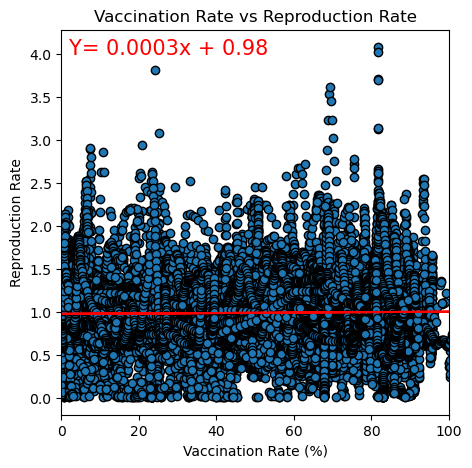

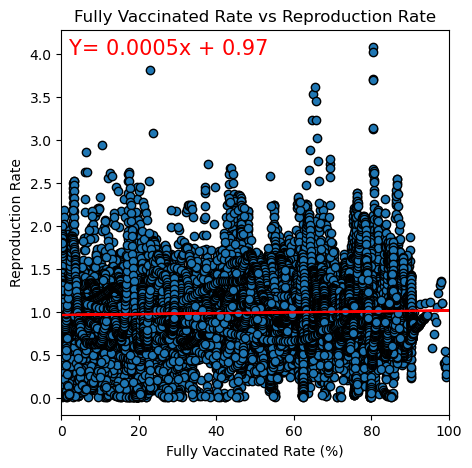

In [88]:
# Analyse connection between Vaccination Rate & Reproduction Rate

## Clean Dataset
### Remove all rows for which we do not have a Reproduction Rate

vaccination_reproduction_df = vaccination_df.drop(vaccination_df[vaccination_df["reproduction_rate"] <= 0].index)

### Remove all rows for which we do not have any vaccinated people

vaccination_reproduction_df = vaccination_reproduction_df.drop(vaccination_reproduction_df[vaccination_reproduction_df["people_vaccinated"] == 0].index)

## Scatter plot + linear regression for vaccination rate vs. reproduction rate

x_axis = vaccination_reproduction_df["Vaccination Rate"]
y_axis = vaccination_reproduction_df["reproduction_rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Vaccination Rate (%)")
plt.ylabel("Reproduction Rate")
plt.title("Vaccination Rate vs Reproduction Rate")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

# Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for vaccination rate vs reproduction rate is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(2,4),fontsize = 15, color = "red")
plt.savefig("Result\Vaccination Rate vs Reproduction Rate.png")


## Scatter plot + linear regression for full vaccination rate vs. reproduction rate

fully_vaccination_reproduction_df = vaccination_reproduction_df.drop(vaccination_reproduction_df[vaccination_reproduction_df["people_fully_vaccinated"] == 0].index)

x_axis = fully_vaccination_reproduction_df["Fully Vaccinated Rate"]
y_axis = fully_vaccination_reproduction_df["reproduction_rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Fully Vaccinated Rate (%)")
plt.ylabel("Reproduction Rate")
plt.title("Fully Vaccinated Rate vs Reproduction Rate")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

# Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for fully vaccinated rate vs reproduction rate is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(2,4),fontsize = 15, color = "red")
plt.savefig("Result\Fully Vaccinated Rate vs Reproduction Rate.png")



The r-value for vaccination rate vs death rate is: -0.3236041007059785
The r-value for fully vaccinated rate vs death rate is: -0.35934246964816663


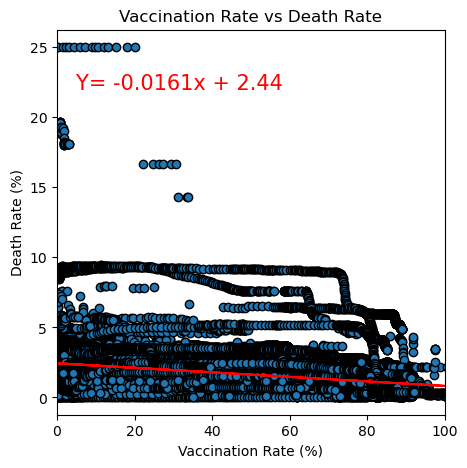

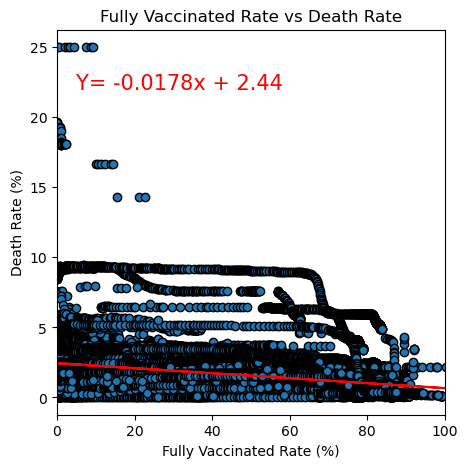

In [89]:
# Analyse connection between Vaccination Rate & Death Rate

## Clean Dataset
### Remove all rows for which we do not have a Death Rate

vaccination_death_df = vaccination_df.drop(vaccination_df[vaccination_df["Death Rate"] == 0].index)

### Remove all rows for which we do not have any vaccinated people

vaccination_death_df = vaccination_death_df.drop(vaccination_death_df[vaccination_death_df["people_vaccinated"] == 0].index)


## Scatter plot + linear regression for vaccination rate vs. reproduction rate

x_axis = vaccination_death_df["Vaccination Rate"]
y_axis = vaccination_death_df["Death Rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Vaccination Rate (%)")
plt.ylabel("Death Rate (%)")
plt.title("Vaccination Rate vs Death Rate")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

# Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for vaccination rate vs death rate is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(5,22),fontsize = 15, color = "red")
plt.savefig("Result\Vaccination Rate vs Death Rate.png")

## Scatter plot + linear regression for fully vaccinated rate vs. reproduction rate

fully_vaccination_death_df = vaccination_death_df.drop(vaccination_death_df[vaccination_death_df["people_fully_vaccinated"] == 0].index)

x_axis = fully_vaccination_death_df["Fully Vaccinated Rate"]
y_axis = fully_vaccination_death_df["Death Rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Fully Vaccinated Rate (%)")
plt.ylabel("Death Rate (%)")
plt.title("Fully Vaccinated Rate vs Death Rate")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

# Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for fully vaccinated rate vs death rate is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(5,22),fontsize = 15, color = "red")
plt.savefig("Result\Fully Vaccinated Rate vs Death Rate.png")


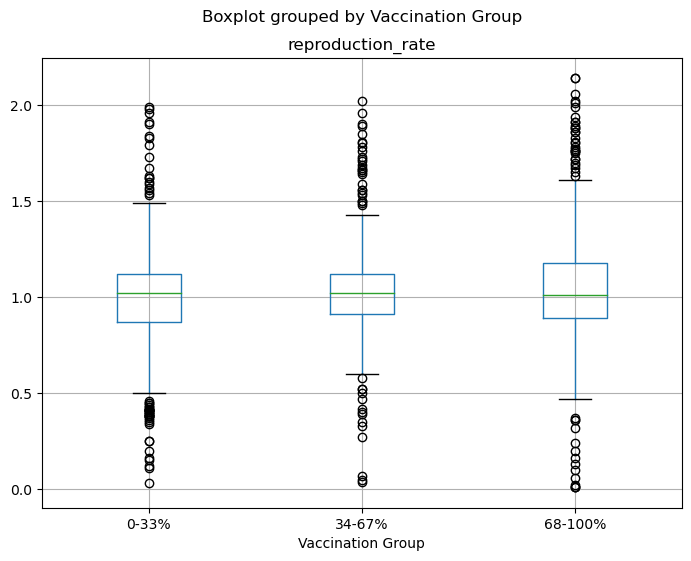

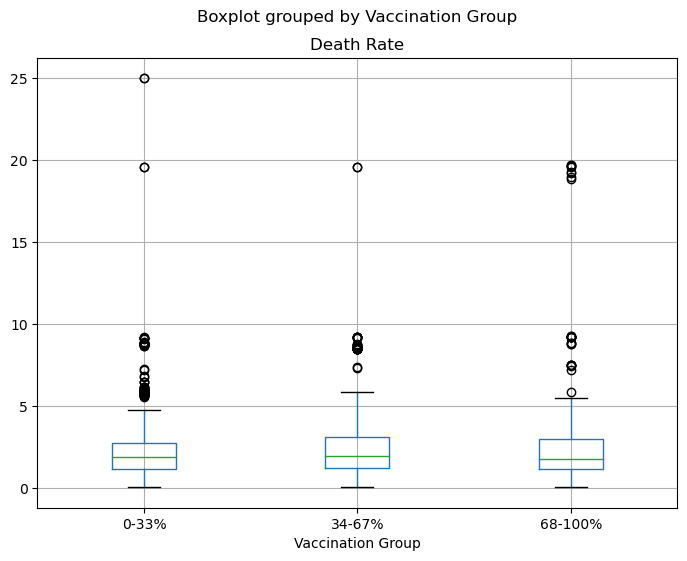

In [90]:
# Analyse connection based on bins

## Add Bins to the data

bins = [0, 0.3333, 0.666, 1]
name_bins = ["0-33%", "34-67%", "68-100%"]

## Vaccination Rate vs Reproduction Rate

vaccination_reproduction_df["Vaccination Group"] = pd.cut(vaccination_reproduction_df["Vaccination Rate"], bins, labels= name_bins, include_lowest=True)

vaccination_reproduction_df.boxplot("reproduction_rate", by="Vaccination Group", figsize=(8, 6))
plt.savefig("Result\Boxplot vaccination rate vs reproduction rate.png")

### Vaccination Rate vs Death Rate

vaccination_death_df["Vaccination Group"] = pd.cut(vaccination_death_df["Vaccination Rate"], bins, labels= name_bins, include_lowest=True)
vaccination_death_df.boxplot("Death Rate", by="Vaccination Group", figsize=(8, 6))
plt.savefig("Result\Boxplot vaccination rate vs death rate.png")



The r-value for vaccination rate vs death rate in Asia is: -0.27592009813663193
The r-value for vaccination rate vs death rate in Europe is: -0.5642277590356817
The r-value for vaccination rate vs death rate in Americas is: -0.27756342850648985


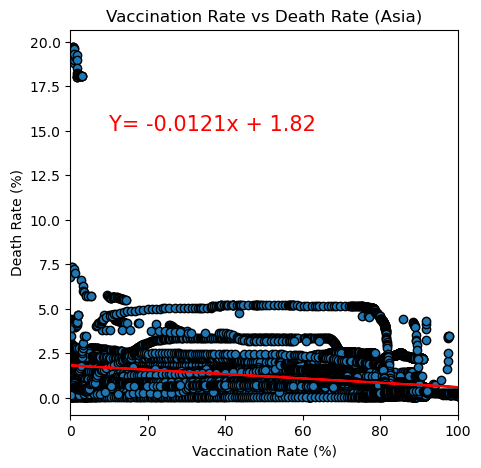

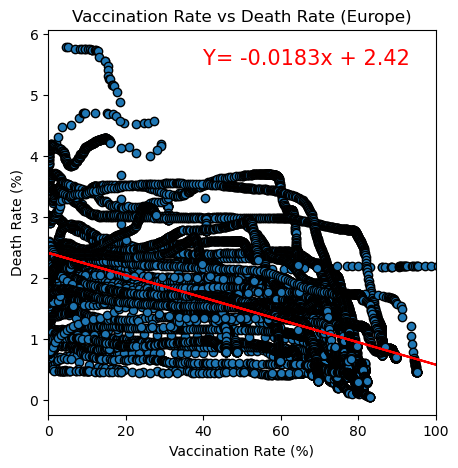

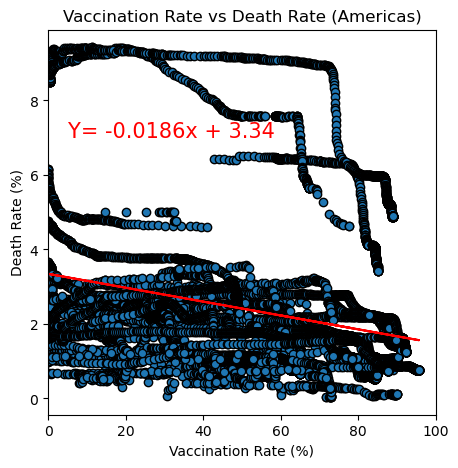

In [91]:
# Split across continents

## Asia

continent_vaccination_death_df = vaccination_death_df.loc[vaccination_death_df["Continent"] == "Asia",:]

### Add Scatter Plot

x_axis = continent_vaccination_death_df["Vaccination Rate"]
y_axis = continent_vaccination_death_df["Death Rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Vaccination Rate (%)")
plt.ylabel("Death Rate (%)")
plt.title("Vaccination Rate vs Death Rate (Asia)")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

### Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for vaccination rate vs death rate in Asia is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(10,15),fontsize = 15, color = "red")
plt.savefig("Result\Vaccination Rate vs Death Rate (Asia).png")


## Europe

continent_vaccination_death_df = vaccination_death_df.loc[vaccination_death_df["Continent"] == "Europe",:]

### Add Scatter Plot

x_axis = continent_vaccination_death_df["Vaccination Rate"]
y_axis = continent_vaccination_death_df["Death Rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Vaccination Rate (%)")
plt.ylabel("Death Rate (%)")
plt.title("Vaccination Rate vs Death Rate (Europe)")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

### Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for vaccination rate vs death rate in Europe is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(40,5.5),fontsize = 15, color = "red")
plt.savefig("Result\Vaccination Rate vs Death Rate (Europe).png")


## Americas

continent_vaccination_death_df = vaccination_death_df.loc[vaccination_death_df["Continent"] == "Americas",:]

### Add Scatter Plot

x_axis = continent_vaccination_death_df["Vaccination Rate"]
y_axis = continent_vaccination_death_df["Death Rate"]

plt.figure(figsize=(5,5))
plt.tight_layout()
plt.xlabel("Vaccination Rate (%)")
plt.ylabel("Death Rate (%)")
plt.title("Vaccination Rate vs Death Rate (Americas)")
plt.xlim(0, 100)

plt.scatter(x_axis,y_axis,marker="o",edgecolors="black")

### Add linear regression

(slope, intercept, rvalues, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "Y= " + str(round(slope,4)) + "x + " + str(round(intercept,2))
print("The r-value for vaccination rate vs death rate in Americas is: " + str(rvalues))
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, xy=(5,7),fontsize = 15, color = "red")
plt.savefig("Result\Vaccination Rate vs Death Rate (Americas).png")



Factor 4: Impact of Air Pollution Rate on the spread of Covid-19 (Xing Ying Chen)

In [105]:
air_pollution_df

,Rank,Country/Region,2021,2020,2019,2018,Population
0,1,Bangladesh,76.9,77.1,83.3,97.1,164689383
1,2,Chad,75.9,-,-,-,16425859
2,3,Pakistan,66.8,59,65.8,74.3,220892331
3,4,Tajikistan,59.4,30.9,-,-,9537642
4,5,India,58.1,51.9,58.1,72.5,1380004385
...,...,...,...,...,...,...,...
112,113,"Bonaire, Saint Eustatius and Saba",5.1,-,-,-,26221
113,114,Cape Verde,5.1,-,-,-,555988
114,115,Puerto Rico,4.8,3.7,10.2,13.7,2860840
115,116,U.S. Virgin Islands,4.5,3.7,3.5,-,104423


In [106]:
covid_country_df

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,West Bank and Gaza,10621,78,3752,6791,152,2,0,0.73,35.33,2.08,8916,1705,19.12,Eastern Mediterranean
183,Western Sahara,10,1,8,1,0,0,0,10.00,80.00,12.50,10,0,0.00,Africa
184,Yemen,1691,483,833,375,10,4,36,28.56,49.26,57.98,1619,72,4.45,Eastern Mediterranean
185,Zambia,4552,140,2815,1597,71,1,465,3.08,61.84,4.97,3326,1226,36.86,Africa


In [107]:
air_pollution_df=pd.merge(air_pollution_df,covid_country_df,on="Country/Region",how="inner")
air_pollution_df

,Rank,Country/Region,2021,2020,2019,2018,Population,Confirmed,Deaths,Recovered,...,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,1,Bangladesh,76.9,77.1,83.3,97.1,164689383,226225,2965,125683,...,2772,37,1801,1.31,55.56,2.36,207453,18772,9.05,South-East Asia
1,2,Chad,75.9,-,-,-,16425859,922,75,810,...,7,0,0,8.13,87.85,9.26,889,33,3.71,Africa
2,3,Pakistan,66.8,59,65.8,74.3,220892331,274289,5842,241026,...,1176,20,3592,2.13,87.87,2.42,266096,8193,3.08,Eastern Mediterranean
3,4,Tajikistan,59.4,30.9,-,-,9537642,7235,60,6028,...,43,1,58,0.83,83.32,1.00,6921,314,4.54,Europe
4,5,India,58.1,51.9,58.1,72.5,1380004385,1480073,33408,951166,...,44457,637,33598,2.26,64.26,3.51,1155338,324735,28.11,South-East Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,108,Estonia,5.9,5.9,6.2,7.2,1326539,2034,69,1923,...,0,0,1,3.39,94.54,3.59,2021,13,0.64,Europe
100,109,Australia,5.7,7.6,8,6.8,25499881,15303,167,9311,...,368,6,137,1.09,60.84,1.79,12428,2875,23.13,Western Pacific
101,110,Bahamas,5.5,-,-,-,393248,382,11,91,...,40,0,0,2.88,23.82,12.09,174,208,119.54,Americas
102,111,Grenada,5.5,-,-,-,112519,23,0,23,...,0,0,0,0.00,100.00,0.00,23,0,0.00,Americas


In [108]:
#rename and drop columns

covid_air_pollution_df=air_pollution_df.drop(columns=['New cases','New deaths','New recovered','Deaths / 100 Cases','Active','Recovered / 100 Cases','Deaths / 100 Recovered','Confirmed last week','1 week change','1 week % increase']).copy()

covid_air_pollution_df


,Rank,Country/Region,2021,2020,2019,2018,Population,Confirmed,Deaths,Recovered,WHO Region
0,1,Bangladesh,76.9,77.1,83.3,97.1,164689383,226225,2965,125683,South-East Asia
1,2,Chad,75.9,-,-,-,16425859,922,75,810,Africa
2,3,Pakistan,66.8,59,65.8,74.3,220892331,274289,5842,241026,Eastern Mediterranean
3,4,Tajikistan,59.4,30.9,-,-,9537642,7235,60,6028,Europe
4,5,India,58.1,51.9,58.1,72.5,1380004385,1480073,33408,951166,South-East Asia
...,...,...,...,...,...,...,...,...,...,...,...
99,108,Estonia,5.9,5.9,6.2,7.2,1326539,2034,69,1923,Europe
100,109,Australia,5.7,7.6,8,6.8,25499881,15303,167,9311,Western Pacific
101,110,Bahamas,5.5,-,-,-,393248,382,11,91,Americas
102,111,Grenada,5.5,-,-,-,112519,23,0,23,Americas


In [109]:
covid_air_pollution_df=covid_air_pollution_df.rename(columns={"Rank":"Pollution Rank",
                                 "2021":"2021 Pollution Rank",
                                "2020":"2020 Pollution Rank",
                                "2019":"2019 Pollution Rank",
                                "2018":"2018 Pollution Rank",
                                "Confirmed":"Confirmed_Covid_Cases",
                                "Death":"Death_Covid_Cases",
                                "Recovered":"Recovered_Covid_Cases"})
covid_air_pollution_df


,Pollution Rank,Country/Region,2021 Pollution Rank,2020 Pollution Rank,2019 Pollution Rank,2018 Pollution Rank,Population,Confirmed_Covid_Cases,Deaths,Recovered_Covid_Cases,WHO Region
0,1,Bangladesh,76.9,77.1,83.3,97.1,164689383,226225,2965,125683,South-East Asia
1,2,Chad,75.9,-,-,-,16425859,922,75,810,Africa
2,3,Pakistan,66.8,59,65.8,74.3,220892331,274289,5842,241026,Eastern Mediterranean
3,4,Tajikistan,59.4,30.9,-,-,9537642,7235,60,6028,Europe
4,5,India,58.1,51.9,58.1,72.5,1380004385,1480073,33408,951166,South-East Asia
...,...,...,...,...,...,...,...,...,...,...,...
99,108,Estonia,5.9,5.9,6.2,7.2,1326539,2034,69,1923,Europe
100,109,Australia,5.7,7.6,8,6.8,25499881,15303,167,9311,Western Pacific
101,110,Bahamas,5.5,-,-,-,393248,382,11,91,Americas
102,111,Grenada,5.5,-,-,-,112519,23,0,23,Americas


In [110]:
covid_air_pollution_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pollution Rank         104 non-null    int64  
 1   Country/Region         104 non-null    object 
 2   2021 Pollution Rank    104 non-null    float64
 3   2020 Pollution Rank    104 non-null    object 
 4   2019 Pollution Rank    104 non-null    object 
 5   2018 Pollution Rank    104 non-null    object 
 6   Population             104 non-null    int64  
 7   Confirmed_Covid_Cases  104 non-null    int64  
 8   Deaths                 104 non-null    int64  
 9   Recovered_Covid_Cases  104 non-null    int64  
 10  WHO Region             104 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 9.8+ KB


###### replace - with 0.0 for mathmatical reason 

In [111]:
covid_air_pollution_df['2020 Pollution Rank']=covid_air_pollution_df['2020 Pollution Rank'].replace('-',np.nan)
covid_air_pollution_df['2019 Pollution Rank']=covid_air_pollution_df['2019 Pollution Rank'].replace('-',np.nan)
covid_air_pollution_df['2018 Pollution Rank']=covid_air_pollution_df['2018 Pollution Rank'].replace('-',np.nan)

In [112]:
covid_air_pollution_df['2020 Pollution Rank']=covid_air_pollution_df['2020 Pollution Rank'].astype(float)
covid_air_pollution_df['2019 Pollution Rank']=covid_air_pollution_df['2019 Pollution Rank'].astype(float)
covid_air_pollution_df['2018 Pollution Rank']=covid_air_pollution_df['2018 Pollution Rank'].astype(float)

In [117]:

covid_air_pollution_df[['2018 Pollution Rank', '2019 Pollution Rank', '2020 Pollution Rank', '2021 Pollution Rank']].ffill(axis=0,inplace=True)


C:\Users\19178\AppData\Local\Temp\ipykernel_19584\1708884951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_air_pollution_df[['2018 Pollution Rank', '2019 Pollution Rank', '2020 Pollution Rank', '2021 Pollution Rank']].ffill(axis=0,inplace=True)


In [114]:
covid_air_pollution_df['Average Pollution Rank'] = covid_air_pollution_df[['2018 Pollution Rank', '2019 Pollution Rank', '2020 Pollution Rank', '2021 Pollution Rank']].mean(axis=1)
#print(covid_air_pollution_df.head())
covid_air_pollution_df

#covid_air_pollution_df['Average Pollution Rank'] = average_ranks
#print(covid_air_pollution_df[['Country/Region', 'Average Pollution Rank']])


,Pollution Rank,Country/Region,2021 Pollution Rank,2020 Pollution Rank,2019 Pollution Rank,2018 Pollution Rank,Population,Confirmed_Covid_Cases,Deaths,Recovered_Covid_Cases,WHO Region,Average Pollution Rank
0,1,Bangladesh,76.9,77.1,83.3,97.1,164689383,226225,2965,125683,South-East Asia,83.600
1,2,Chad,75.9,NaN,NaN,NaN,16425859,922,75,810,Africa,75.900
2,3,Pakistan,66.8,59.0,65.8,74.3,220892331,274289,5842,241026,Eastern Mediterranean,66.475
3,4,Tajikistan,59.4,30.9,NaN,NaN,9537642,7235,60,6028,Europe,45.150
4,5,India,58.1,51.9,58.1,72.5,1380004385,1480073,33408,951166,South-East Asia,60.150
...,...,...,...,...,...,...,...,...,...,...,...,...
99,108,Estonia,5.9,5.9,6.2,7.2,1326539,2034,69,1923,Europe,6.300
100,109,Australia,5.7,7.6,8.0,6.8,25499881,15303,167,9311,Western Pacific,7.025
101,110,Bahamas,5.5,NaN,NaN,NaN,393248,382,11,91,Americas,5.500
102,111,Grenada,5.5,NaN,NaN,NaN,112519,23,0,23,Americas,5.500


In [115]:
covid_complete_df.rename(columns={"Country/Region":"Country"},inplace=True)
summary_covid_complete_df = covid_complete_df.groupby(["Country"]).sum()
summary_air_quality_df=air_quality_df.groupby(["Country"]).sum()
merge_df=pd.merge(summary_covid_complete_df,summary_air_quality_df,on="Country")
merge_df

,Lat,Long,Confirmed,Deaths,Recovered,Active,AirQuality,WaterPollution
Country,,,,,,,,
